# Projekt - EDA z uwzględnieniem czynnika przestrzennego 

## Autor: Grzegorz Cichy


## Celem projektu jest wykonanie EDA dla danych dotyczących zanieczyszczenia powietrza, pochodzących z bazy WHO. Zbiór danych zawiera pomiary z różnych lokalizacji na świecie, podzielone na kraje oraz miasta.

## Szczegółowa instrukcja wykonania:

1. Wczytaj dane zanieczyszczenia powietrza z bazy WHO do odpowiedniej struktury danych, np. DataFrame w Pythonie. Spróbuj również wykorzytsać bibliotekę ITables 2.0 i napisz czy wnosi ona wartość użytkową w przypadku danych używanych w tym projekcie. 
2. Przeprowadź eksploracyjną analizę danych (EDA) dla różnych poziomów generalizacji - regionu, kraju i miasta. Wykorzystaj różne techniki analizy danych poznane na wykładzie.
3. Przeprowadź analizę na różnych poziomach generalizacji i skomentuj, jakie są różnice w interpretacji wyników w zależności od tego, czy analizujesz dane na poziomie regionu, kraju czy miasta
4. Przedstaw analizę również za pomocą mapy, aby zobrazować geograficzne rozkłady zanieczyszczenia powietrza w różnych regionach.
5. Na podstawie przeprowadzonej analizy, znajdź potencjalne związki przyczynowo-skutkowe między różnymi zmiennymi. Skomentuj, jakie wnioski można wyciągnąć na temat wpływu zanieczyszczenia powietrza na dane regiony, kraje i miasta.
6. Zastanów się, jakie potencjalne zastosowania ma ten rodzaj danych w uczeniu maszynowym, na przykład jako dane wejściowe do modeli przewidujących jakość powietrza w przyszłości.
7. Przedstaw swoje wnioski w formie podsumowania, uwzględniając interpretacje uzyskanych wyników oraz wnioski dotyczące zastosowań w uczeniu maszynowym.




<br><br>

### Import używanych bibliotek:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import itables 
from itables import show
from itables import init_notebook_mode
import copy
import geopandas as gpd


### Wczytanie danych:

Dane pochodzą ze strony: **https://www.who.int/data/gho/data/themes/air-pollution/who-air-quality-database**. Zawierają informacje o zanieczyszczeniu powietrza w lokacjach na całym świecie jako uśredniona średnia roczna. Badane zanieczyszczenia to stężenie pyłów zawieszonych PM10 oraz PM25, a także stężenie dwutlenku azotu NO2.

**Szczegółowy opis kolumn:**

- Measurement Year: Rok pomiaru.
- PM2.5 (μg/m3): Stężenie pyłów PM2.5 w mikrogramach na metr sześcienny.
- PM10 (μg/m3): Stężenie pyłów PM10 w mikrogramach na metr sześcienny.
- NO2 (μg/m3): Stężenie dwutlenku azotu (NO2) w mikrogramach na metr sześcienny.
- PM25 temporal coverage (%): Pokrycie czasowe danych dotyczących pyłów PM2.5 (%).
- PM10 temporal coverage (%): Pokrycie czasowe danych dotyczących pyłów PM10 (%).
- NO2 temporal coverage (%): Pokrycie czasowe danych dotyczących dwutlenku azotu (%).
- Reference: Odwołanie do źródła danych.
- Number and type of monitoring stations: Liczba i typ stacji monitorujących.
- Version of the database: Wersja bazy danych.
- Status: Status danych.

In [2]:
init_notebook_mode(connected=True)

c:\Users\gcich\AppData\Local\Programs\Python\Python310\lib\site-packages\itables\javascript.py:108: UserWarning: Did you know? init_notebook_mode(all_interactive=False, connected=True) does nothing. Feel free to remove this line, or pass warn_if_call_is_superfluous=False.
  warnings.warn(


In [3]:
df = pd.read_excel('who_aap_2021_v9_11august2022.xlsx', sheet_name='AAP_2022_city_v9')

new_cols = {'WHO Region' : 'Region', 
            'WHO Country Name' : 'Country', 
            'City or Locality': 'City',
            'Measurement Year' : 'Year'}
df.rename(columns = new_cols,inplace = True)
df.head(10)
show(df, column_filters='header', search={"regex": True, "caseInsensitive": True})

Loading... (need help?)


Użycie biblioteki Itables umożliwia interaktywne wyświetlanie danych w jupyter notebooks, filtrację, dostosowanie ilości elementów na stronie, czy wyszukiwanie wg regexu. Zdecydowanie biblioteka Itables wnosi wartość użytkową i będę z niej korzystać w przyszłości.

**Podstawowe informacje o danych**

Typy kolumn:

In [4]:
df.dtypes

Region                                     object
ISO3                                       object
Country                                    object
City                                       object
Year                                        int64
PM2.5 (μg/m3)                             float64
PM10 (μg/m3)                              float64
NO2 (μg/m3)                               float64
PM25 temporal coverage (%)                float64
PM10 temporal coverage (%)                float64
NO2 temporal coverage (%)                 float64
Reference                                  object
Number and type of monitoring stations     object
Version of the database                     int64
Status                                    float64
dtype: object

Podstawowe statystyki opisowe:

In [5]:
df.describe()

,Year,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Version of the database,Status
count,32191.000000,15048.000000,21109.000000,22200.000000,7275.000000,5381.000000,19890.000000,32191.000000,0.0
mean,2015.579354,22.920320,30.533252,20.619336,90.794096,90.583500,93.696804,2021.744214,NaN
std,2.752654,17.925906,29.312756,12.133388,14.872681,13.816311,10.451751,1.051897,NaN
min,2000.000000,0.010000,1.040000,0.000000,0.000000,2.568493,1.923077,2016.000000,NaN
25%,2014.000000,10.350000,16.980000,12.000000,88.595890,87.945205,93.207763,2022.000000,NaN
50%,2016.000000,16.000000,22.000000,18.800000,97.000000,96.039000,96.369863,2022.000000,NaN
75%,2018.000000,31.000000,31.300000,27.160000,99.000000,98.938000,98.926941,2022.000000,NaN
max,2021.000000,191.900000,540.000000,210.680000,100.000000,100.000000,100.000000,2022.000000,NaN


### **Wartości brakujące:**

In [6]:
df_null = pd.concat([np.round(df.isnull().sum()/len(df)*100,3), df.isnull().sum()], axis=1)
df_null.columns = ['null percent', 'null count']
df_null

,null percent,null count
Region,0.003,1
ISO3,0.000,0
Country,0.000,0
City,0.000,0
Year,0.000,0
PM2.5 (μg/m3),53.254,17143
PM10 (μg/m3),34.426,11082
NO2 (μg/m3),31.037,9991
PM25 temporal coverage (%),77.401,24916
PM10 temporal coverage (%),83.284,26810


W zbiorze danych znajduje się bardzo dużo brakujących danych. Kluczowe z punktu widzenia analizy zanieczyszczenia powietrza są kolumny:
- 'PM2.5 (μg/m3)' - 53.254% brakujących danych
- 'PM10 (μg/m3)' - 34.426% brakujących danych
- 'NO2 (μg/m3)', - 31.037% brakujących danych
- 'PM25 temporal coverage (%)' - 77.401% brakujących danych
- 'PM10 temporal coverage (%)' - 83.284% brakujących danych
- 'NO2 temporal coverage (%)' - 38.213% brakujących danych

W każdej z tych kolumn braki są na tyle duże, że nie można pozwolić sobie na usunięcie wierszy z brakami - trzeba będzie w jakiś sposób uzupełnić braki w danych.

Jeśli chodzi o kolumny 'Reference','Number and type of monitoring stations', 'Version of the database' - oceniona zostanie ich przydatność w analizie i jeśli okażą się nieprzydatne to zostaną pominięte.

Kolumna 'Status' jest do do pominięcia, ponieważ zawiera jedynie wartości brakujące.

Kolumns 'Version of the database' jest do pominięcia, ponieważ wersja bazy danych nie ma potencjału, żeby wnieść cokolwiek do analizy. 

Zbadany zostanie również brak wartości w 1 wierszu dla kolumny region.

In [7]:
df_filled = copy.deepcopy(df)
del df_filled['Status']
del df_filled['Version of the database']

**1. Braki w kolumnie 'Region':**

In [8]:
print(df_filled['Region'].unique())
df_filled[df_filled['Region'].isnull()]

['Eastern Mediterranean Region' 'European Region' 'Region of the Americas'
 'Western Pacific Region' 'South East Asia Region' 'African Region' nan]


,Region,ISO3,Country,City,Year,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Reference,Number and type of monitoring stations
24778,NaN,LIE,Liechtenstein,Vaduz,2010,NaN,17.88,23.59,NaN,96.164,98.265,European Environment Information and Observati...,NaN


Lichtenstein jest państwem europejskim, dlatego wartość nan może być zastąpiona przez 'European Region'

In [9]:

df_filled.loc[24778,'Region'] = 'European Region'
df_filled.loc[24778,]

Region                                                                      European Region
ISO3                                                                                    LIE
Country                                                                       Liechtenstein
City                                                                                  Vaduz
Year                                                                                   2010
PM2.5 (μg/m3)                                                                           NaN
PM10 (μg/m3)                                                                          17.88
NO2 (μg/m3)                                                                           23.59
PM25 temporal coverage (%)                                                              NaN
PM10 temporal coverage (%)                                                           96.164
NO2 temporal coverage (%)                                                       

**2. Braki w kolumnie 'Reference':**

In [10]:
df_filled[df_filled['Reference'].isnull()]

,Region,ISO3,Country,City,Year,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Reference,Number and type of monitoring stations
28209,Eastern Mediterranean Region,QAT,Qatar,Doha,2017,44.0,148.0,29.0,98.0,96.0,99.0,NaN,"Roadside, residential and commercial area"
28210,Eastern Mediterranean Region,QAT,Qatar,Doha,2018,44.0,181.0,47.0,99.0,97.0,99.0,NaN,"Roadside, residential and commercial area"
28211,Eastern Mediterranean Region,QAT,Qatar,Doha,2019,41.0,208.0,42.0,97.0,97.0,99.0,NaN,"Roadside, residential and commercial area"
28212,Eastern Mediterranean Region,QAT,Qatar,Doha,2020,33.0,108.0,28.0,98.0,98.0,99.0,NaN,"Roadside, residential and commercial area"
28213,Eastern Mediterranean Region,QAT,Qatar,Doha,2021,38.0,150.0,30.0,97.0,96.0,99.0,NaN,"Roadside, residential and commercial area"


Nie jest możliwe przewidzenie źródła danych, dlatego te wartości pozostaną jako NaN

**3. Braki w kolumnie 'Number and type of monitoring stations':**

In [11]:
print("Unikalne wartości w kolumnie 'Number and type of monitoring stations': \n")
print(df_filled['Number and type of monitoring stations'].unique())
print("\n\nIlość unikalnych wartości w kolumnie 'Number and type of monitoring stations': " + str(len(df_filled['Number and type of monitoring stations'].unique())) + '\n')
show(df_filled[df_filled['Number and type of monitoring stations'].isnull()])

Unikalne wartości w kolumnie 'Number and type of monitoring stations': 

[nan '1 City Centre, 1 Industrial, 1 Road Side, 2 Urban/ Residential'
 '1 City Centre, 2 Industrial, 1 Road Side, 2 Urban/ Residential'
 '1 City Centre, 2 Industrial, 1 Road Side, 4 Urban/ Residential'
 '1 down town, 2 Down Town, 3 Industrial, 2 Reference, 1 Reference-Industrial, 2 traffic, 8 Urban/Residential / FOR PM2.5 : US embassy'
 '1 down town, 2 Down Town, 3 Industrial, 2 Reference, 1 Reference-Industrial, 2 traffic, 8 Urban/Residential/ FOR PM2.5 : US embassy'
 '1 down town, 2 Down Town, 3 Industrial, 2 Reference, 1 Reference-Industrial, 3 traffic, 1 Traffic, 8 Urban/Residential'
 '1 Residential' '1 industrial, 4 Residential'
 '1 industrial, 6 Residential' '1 Road Side, 1 Urban/ Residential'
 '1 City Centre, 1 Road Side, 2 Urban/ Residential'
 '1 City Centre, 1 Regional Background, 1 Road Side, 3 Urban/ Residential'
 '1 City Centre, 1 Regional Background, 1 Urban/ Residential'
 '1 City Centre, 1 Industrial

In [12]:
df_null_natoms = df_filled[df_filled['Number and type of monitoring stations'].isnull()]
df_no_null_natoms = df_filled[df_filled['Number and type of monitoring stations'].notnull()]
df_missing_natoms = pd.concat([np.round(df_null_natoms.isnull().sum()/len(df_null_natoms)*100,3), np.round(df_no_null_natoms.isnull().sum()/len(df_no_null_natoms)*100,3)], axis=1)
df_missing_natoms.columns = ['natoms null - null percent', 'natoms not null - null percent']
df_missing_natoms

,natoms null - null percent,natoms not null - null percent
Region,0.000,0.000
ISO3,0.000,0.000
Country,0.000,0.000
City,0.000,0.000
Year,0.000,0.000
PM2.5 (μg/m3),49.200,64.101
PM10 (μg/m3),36.030,30.132
NO2 (μg/m3),34.055,22.962
PM25 temporal coverage (%),80.719,68.520
PM10 temporal coverage (%),96.885,46.894


Porównując braki w kolumnach dla obserwacji gdzie 'Number and type of monitoring stations' jest nullem vs gdzie nie jest, widoczny jest związek braku wartości w kolumnie 'PM10 temporal coverage (%)' z brakiem wartości w kolumnie 'Number and type of monitoring stations'. Jeśli 'Number and type of monitoring stations' jest nullem to w 96% przypadków 'PM10 temporal coverage (%)' jest nullem, natomiast w przeciwnym wypadku, jedynie 46% wartości 'P'M10 temporal coverage (%)' jest nullem.

Ta zależność nie pomaga jednak w potencjalnym przewidzeniu wartości 'Number and type of monitoring stations', również ze względu na to, że istnieje aż 635 unikalnych etykiet w tej kolumnie. Z tego powodu wartości brakujące w tej kolumnie nie zostaną uzupełnione.

**4. Braki w kolumnach 'PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)', 'PM25 temporal coverage (%)', 'PM10 temporal coverage (%)', 'NO2 temporal coverage (%)':**

Rozkłady wartości zmiennych:

C:\Users\gcich\AppData\Local\Temp\ipykernel_2480\365852356.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0, :3])
c:\Users\gcich\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


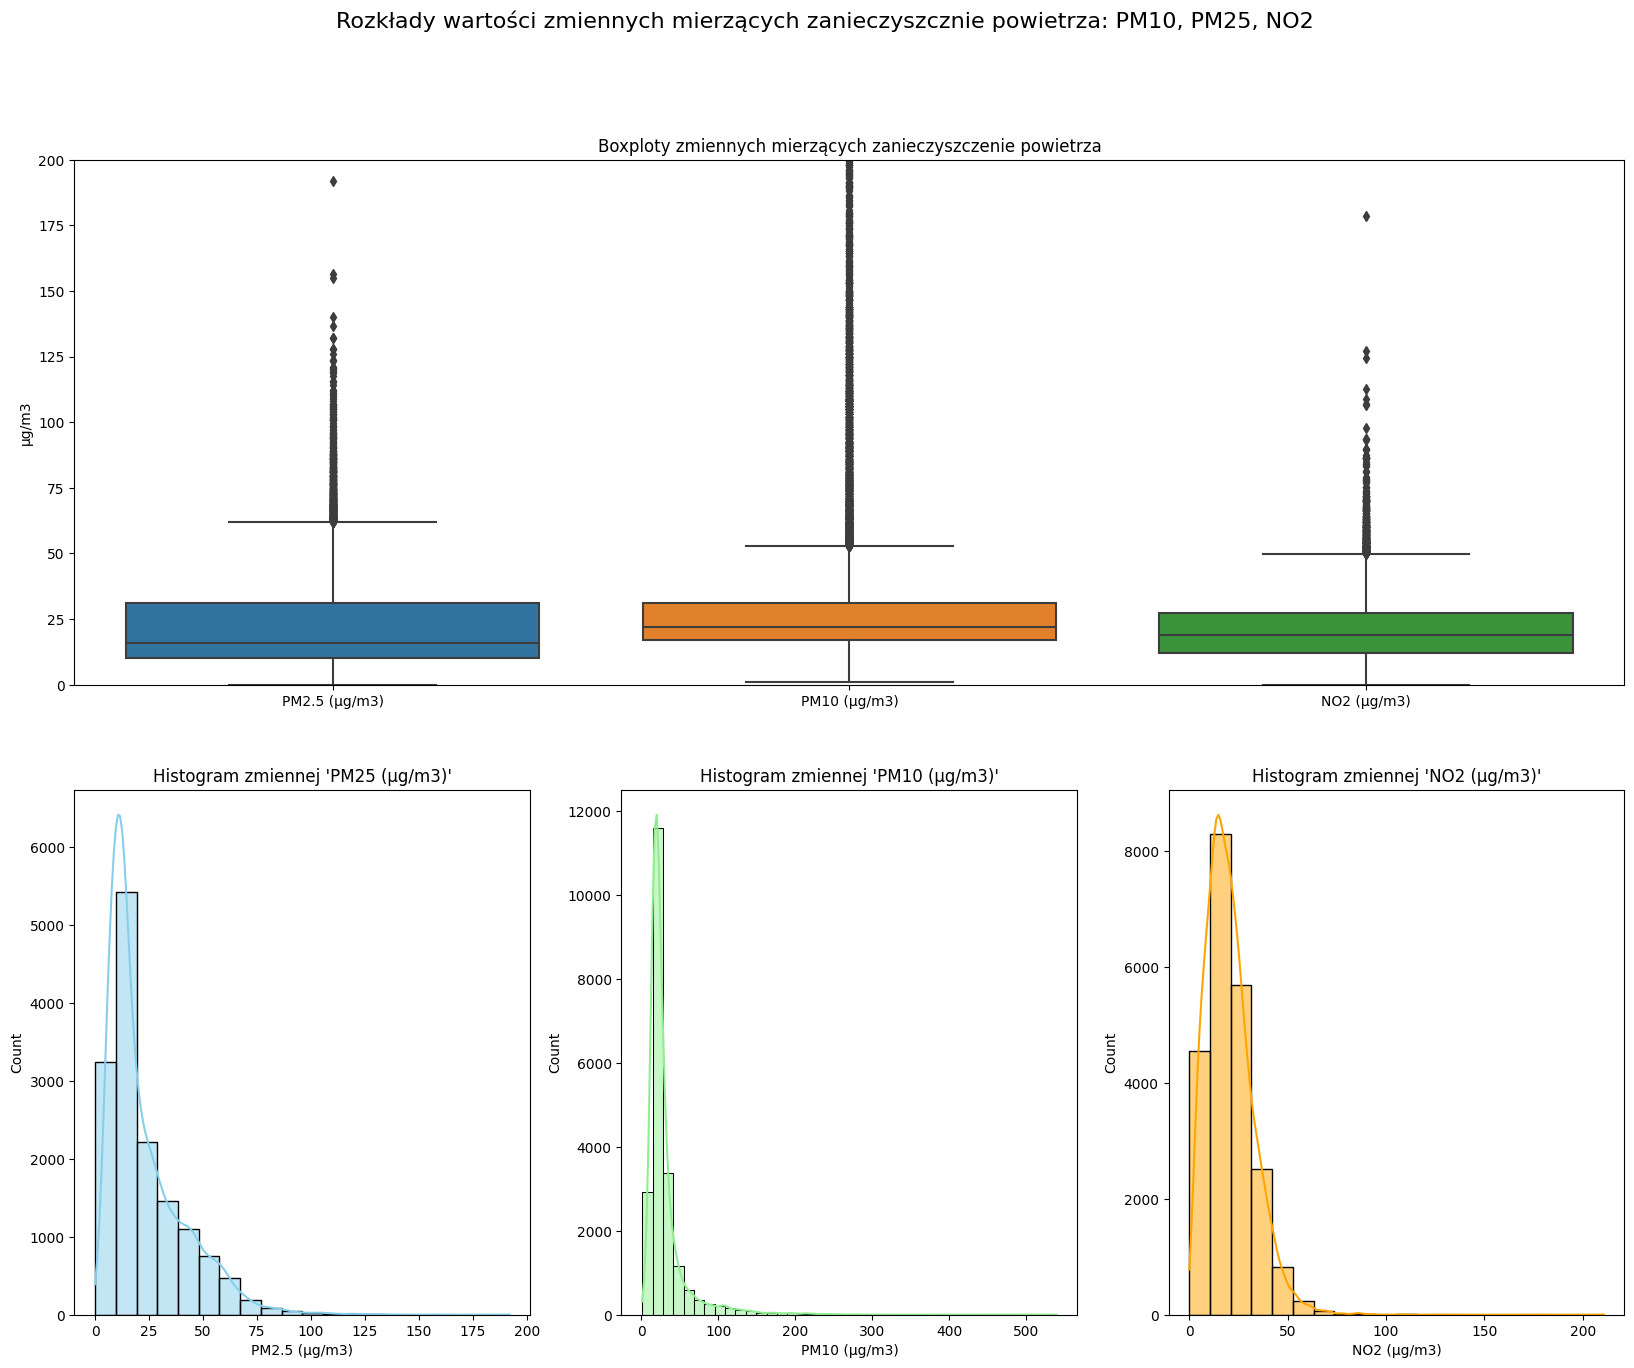

In [13]:
from matplotlib.gridspec import GridSpec

fig, ax = plt.subplots(1,2, figsize=(20,15))
gs = GridSpec(2, 3, figure=fig)

ax1 = plt.subplot(gs[0, :3])
sns.boxplot(df_filled[['PM2.5 (μg/m3)','PM10 (μg/m3)','NO2 (μg/m3)']], ax=ax1)
ax1.set_title('Boxploty zmiennych mierzących zanieczyszczenie powietrza')
ax1.set_ylabel('μg/m3')
ax1.set_ylim([0,200])


# Plot on the second row (3 plots)
ax2 = plt.subplot(gs[1, 0])
sns.histplot(df_filled['PM2.5 (μg/m3)'], bins=20, color='skyblue', ax=ax2, kde=True)
ax2.set_title("Histogram zmiennej 'PM25 (μg/m3)'")

ax3 = plt.subplot(gs[1, 1])
sns.histplot(df_filled['PM10 (μg/m3)'], bins=40, color='lightgreen', ax=ax3, kde=True)
ax3.set_title("Histogram zmiennej 'PM10 (μg/m3)'")

ax4 = plt.subplot(gs[1, 2])
sns.histplot(df_filled['NO2 (μg/m3)'],bins=20, color='orange', ax=ax4, kde=True)
ax4.set_title("Histogram zmiennej 'NO2 (μg/m3)'")
plt.suptitle('Rozkłady wartości zmiennych mierzących zanieczyszcznie powietrza: PM10, PM25, NO2', fontsize=16)
plt.show()




Wszystkie zmienne mają zbliżone rozkłady. Charakteryzują się największą ilością zliczeń w okolicach wartości 10-20, a potem następuje gwałtowny spadek zliczeń dla kolejnych przedziałów. Są to rozkłady o dużej prawostronnej skośności.

**Macierz korelacji**

Text(0.5, 1.0, 'Macierz korelacji dla danych dotyczących zanieczyszczenia powietrza')

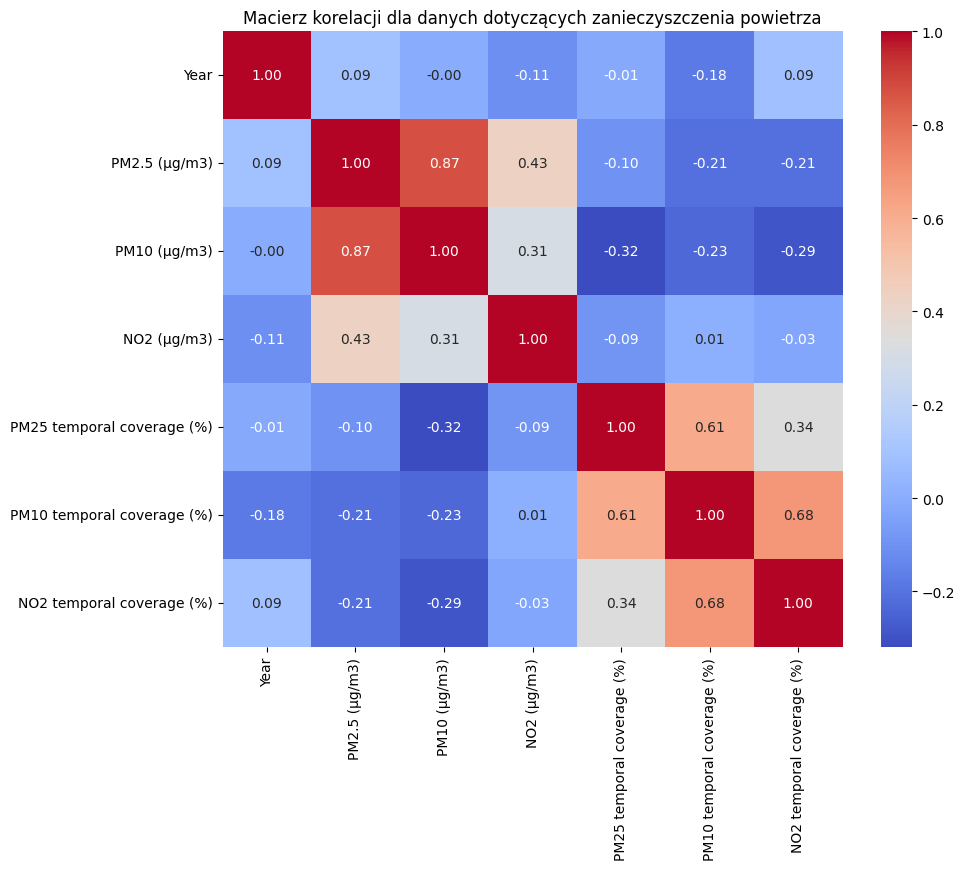

In [14]:
correlation_matrix = df_filled.corr(numeric_only = True)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz korelacji dla danych dotyczących zanieczyszczenia powietrza')

Macierz korelacji wskazuje bardzo dużą korelację między zmiennymi PM10 oraz PM25, a także sporą dodatnią korelację tych zmiennych do zmiennej NO2.

Widoczna jest również duża korelacja zmiennej 'PM10 temporal coverage (%)' z pozostałymi zmiennymi wskazującymi na procent pokrycia pomiarów pozostałych zanieczyszczeń

**Ważna obserwacja:**

Pył zawieszony PM10 to pyły o średnicy <= 10 mikrometrów, natomiast PM2.5 to pyły o średnicy <= 2.5 mikrometra. W teorii zatem wartości stężeń pyłu PM10 powinny być zawsze większe od wartości stężeń pyłów PM2.5.

In [15]:
print('Ilość obserwacji, gdzie stężenie PM10 było mniejsze od stężenie PM2.5:')
temp1 = df_filled[df_filled['PM10 (μg/m3)'] < df_filled['PM2.5 (μg/m3)']]
print(len(temp1))

print('\nIlość obserwacji, gdzie zmierzono zarówno PM10 jak i PM 2.5:')
df_PM_notnull = df_filled[df_filled['PM10 (μg/m3)'].notnull() & df_filled['PM2.5 (μg/m3)'].notnull()]
print(len(df_PM_notnull))

print('\nProcent obserwacji, gdzie stężęnie PM10 było większe niż PM2.5 spośród obserwacji gdzie zmierzono oba wskaźniki:')
print(str(np.round(len(temp1)/len(df_PM_notnull) * 100,3))+'%')

df_filled[df_filled['PM10 (μg/m3)'] < df_filled['PM2.5 (μg/m3)']]


Ilość obserwacji, gdzie stężenie PM10 było mniejsze od stężenie PM2.5:
32

Ilość obserwacji, gdzie zmierzono zarówno PM10 jak i PM 2.5:
8824

Procent obserwacji, gdzie stężęnie PM10 było większe niż PM2.5 spośród obserwacji gdzie zmierzono oba wskaźniki:
0.363%


,Region,ISO3,Country,City,Year,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Reference,Number and type of monitoring stations
2670,Region of the Americas,CAN,Canada,Brandon,2018,11.00,8.00,13.00,99.000000,100.000000,96.000000,Government of Canada,"1 General Population Exposure, Medium Urban Ar..."
2866,Region of the Americas,CAN,Canada,Flin Flon,2018,13.00,12.00,NaN,97.000000,100.000000,NaN,Government of Canada,"1 Transportation Source Influenced, Small Urba..."
8920,Region of the Americas,CRI,Costa Rica,San Jose,2018,22.00,21.75,40.71,100.000000,100.000000,100.000000,"Informe de Calidad del Aire, Área Metropolitan...","28 Urbana, 5 Urbana-Tráfico"
9519,European Region,CZE,Czechia,Stachy,2013,9.44,8.53,4.92,NaN,88.493000,94.240792,"Czech Hydrometeorological Institute, European ...",1 Rural background
9520,European Region,CZE,Czechia,Stachy,2014,9.14,8.98,3.76,NaN,87.945000,91.860628,"Czech Hydrometeorological Institute, European ...",1 Rural background
12656,European Region,ESP,Spain,As Pontes De Garcia Rodriguez,2018,9.63,9.11,3.54,NaN,NaN,97.762557,European Environment Agency (downloaded in 2021),NaN
12657,European Region,ESP,Spain,As Pontes De Garcia Rodriguez,2019,8.99,8.96,3.62,NaN,NaN,97.899543,European Environment Agency (downloaded in 2021),NaN
14053,European Region,ESP,Spain,Oural,2015,10.91,10.79,7.47,NaN,NaN,97.397260,European Environment Agency (downloaded in 2021),NaN
14054,European Region,ESP,Spain,Oural,2016,10.34,10.23,12.77,NaN,NaN,91.757741,European Environment Agency (downloaded in 2021),NaN
14055,European Region,ESP,Spain,Oural,2017,11.64,11.42,17.97,NaN,NaN,97.248858,European Environment Agency (downloaded in 2021),NaN


Jak widać tylko w 0.36% przypadków pomiar PM10 był większy niż PM2.5, może to wynikać z faktu, że oba wskaźniki są zbierane z użyciem różnych metod. 
Mimo tych 32 odstępstw od reguły wydaje się, że brakujące wartości jednego z tych czynników można uzupełnić w oparciu o pomiar drugiego z nich. Argumentem przemawiającym za sensownością tego rozwiązania jest również wysoka korelacja między zmiennymi.

Scenariusze brakujących wartości:

In [16]:
print('Ilość obserwacji, dla których PM10 jest null, a PM2.5 nie jest null:\n')
print(len(df_filled[df_filled['PM10 (μg/m3)'].isnull() & df_filled['PM2.5 (μg/m3)'].notnull()]))
print('\n\nIlość obserwacji, dla których PM10 nie jest null, a PM2.5 jest null:\n')
print(len(df_filled[df_filled['PM10 (μg/m3)'].notnull() & df_filled['PM2.5 (μg/m3)'].isnull()]))
print('\n\nIlość obserwacji, dla których PM10 i PM2.5 są nullami:\n')
print(len(df_filled[df_filled['PM10 (μg/m3)'].isnull() & df_filled['PM2.5 (μg/m3)'].isnull()]))

Ilość obserwacji, dla których PM10 jest null, a PM2.5 nie jest null:

6224


Ilość obserwacji, dla których PM10 nie jest null, a PM2.5 jest null:

12285


Ilość obserwacji, dla których PM10 i PM2.5 są nullami:

4858


**Wniosek:** jeśli uda się skutecznie określić wartość jednej ze zmiennych PM na podstawie drugiej, możliwe będzie uzupełnienie 18500 brakujących wartości.

<br><br>Rozrzut zmiennych PM10 i PM2.5

Text(0.5, 1.0, "Wykres rozrzutu zmiennych 'PM10 (μg/m3)' a 'PM2.5 (μg/m3)'")

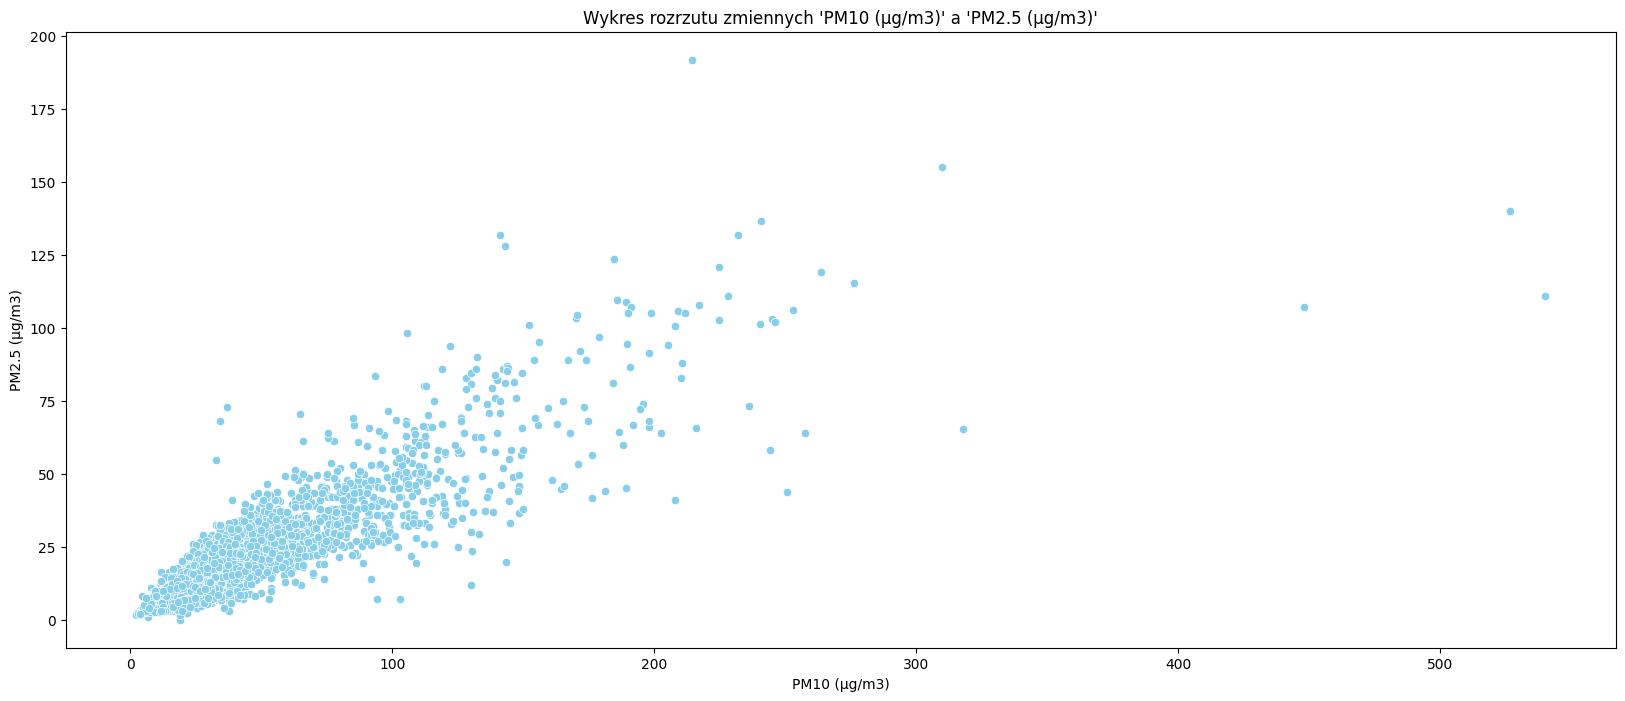

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (20,8))
sns.scatterplot(x= df_filled['PM10 (μg/m3)'], y= df_filled['PM2.5 (μg/m3)'], color='skyblue', ax=ax)
ax.set_title("Wykres rozrzutu zmiennych 'PM10 (μg/m3)' a 'PM2.5 (μg/m3)'")

Między zmiennymi występuje silna liniowa zależność, jednak wraz z rosnącymi wartościami, rośnie wariancja.

Jak prezentują się różnice w wartościach między zmiennymi?

In [18]:
df_PM_notnull['difference'] = df_PM_notnull['PM10 (μg/m3)'] - df_PM_notnull['PM2.5 (μg/m3)']

C:\Users\gcich\AppData\Local\Temp\ipykernel_2480\212400282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PM_notnull['difference'] = df_PM_notnull['PM10 (μg/m3)'] - df_PM_notnull['PM2.5 (μg/m3)']


Text(0.5, 1.0, 'Różnice między zmiennymi, a wzrost PM2.5')

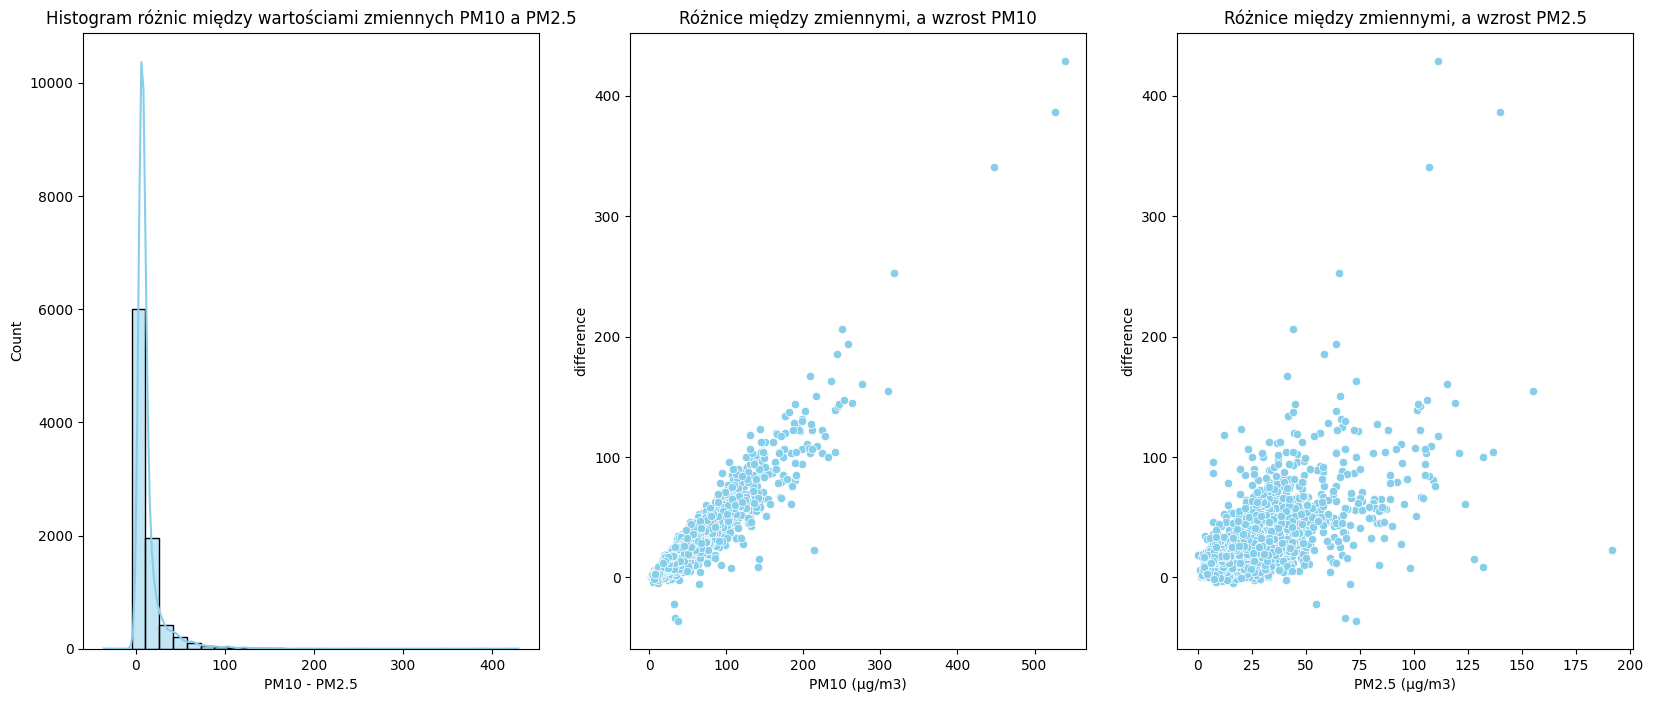

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (20,8))
sns.histplot(df_PM_notnull['difference'], bins=30, color='skyblue', kde=True, ax=ax[0])
ax[0].set_title("Histogram różnic między wartościami zmiennych PM10 a PM2.5")
ax[0].set_xlabel("PM10 - PM2.5")

sns.scatterplot(x = df_PM_notnull['PM10 (μg/m3)'], y = df_PM_notnull['difference'], color='skyblue', ax=ax[1])
ax[1].set_title("Różnice między zmiennymi, a wzrost PM10")


sns.scatterplot(x = df_PM_notnull['PM2.5 (μg/m3)'], y = df_PM_notnull['difference'], color='skyblue', ax=ax[2])
ax[2].set_title("Różnice między zmiennymi, a wzrost PM2.5")




Macierz korelacji różnicy między zmiennymi, a zmiennymi:

Text(0.5, 1.0, 'Macierz korelacji dla danych dotyczących zanieczyszczenia powietrza')

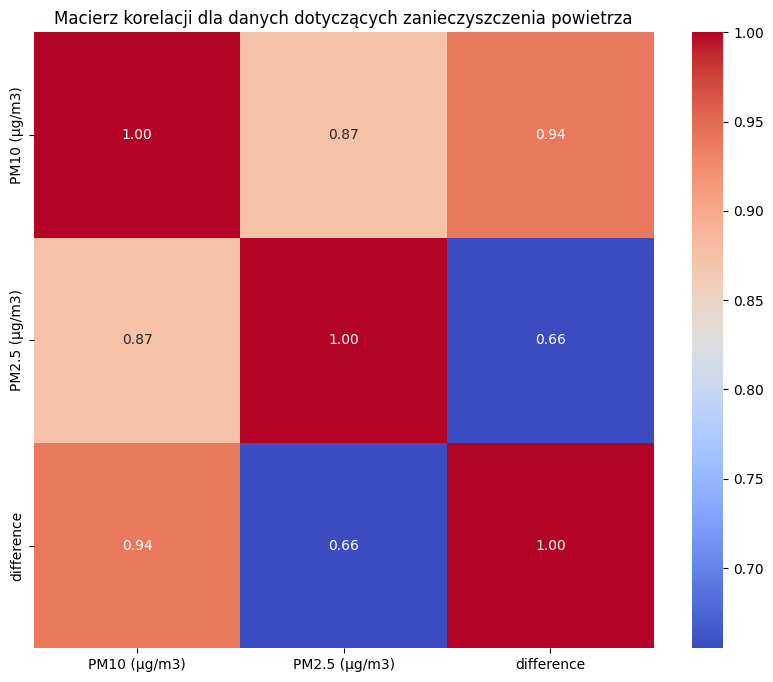

In [20]:
correlation_matrix = df_PM_notnull[['PM10 (μg/m3)','PM2.5 (μg/m3)','difference']].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz korelacji dla danych dotyczących zanieczyszczenia powietrza')

Między wzrostem zmiennych PM, a różnicą pomiarów występuje silna dodatnia korelacja. Na podstawie wykresów rozrzutu, widać, że wzrost jest niemal liniowa. 

Aby zobrazować ten wzrost różnicy, stworzony zostanie model regresji liniowej, który dopasuje proste do tej zależności. Ich równania posłużą do uzupełnienia brakujących wartości, w 2 scenariuszach:
1. Dane jest stężenie PM10, natomiast stężenie PM2.5 jest nullem - w tym przypadku wykorzystany zostanie model dopasowujący różnicę do wartości PM10. Następnie w celu uzyskania wartości PM2.5 różnica zostanie odjęta od wartości stężenia PM10.
2. Dane jest stężenie PM2.5, natomiast stężenie PM10 jest nullem - w tym przypadku wykorzystany zostanie model dopasowujący różnicę do wartości PM2.5. Następnie w celu uzyskania wartości PM10 różnica zostanie dodana do wartości stężenia PM2.5.

<br><br>
**Model regresji w scenariuszu 1**

Coefficients: [[0.58021177]]
Intercept: [-4.21608103]
Mean Squared Error: 54.82713789056055
R-squared: 0.8989620265055163


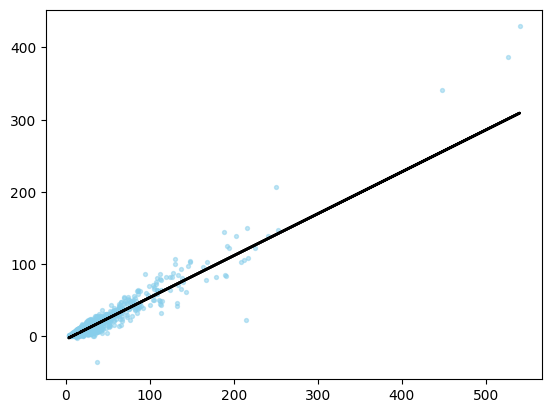

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


X_train, X_test, y_train, y_test = train_test_split(df_PM_notnull['PM10 (μg/m3)'], df_PM_notnull['difference'], test_size=0.2, random_state=45)

# Creating a linear regression model
model_1 = LinearRegression()

X_train = X_train.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
model_1.fit(X_train, y_train)

y_pred = model_1.predict(X_test)

model1_coeff = model_1.coef_
model1_intercept = model_1.intercept_

print("Coefficients:", model1_coeff)
print("Intercept:", model1_intercept)

# # Mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
# Plotting the data and the regression line
plt.scatter(X_test, y_test, color='skyblue', s=8, alpha=0.5)
plt.plot(X_test, y_pred, color='black', linewidth=2)

plt.show()

Model dla 1 scenariusza ma wysoki współczynik R2 wynoszący więcej niż 0.85 i wydaje się być dobrze dopasowanym do trendu.

<br><br>
**Model regresji w scenariuszu 2**

Coefficients: [[1.93799283]]
Intercept: [-2.51610007]
Mean Squared Error: 118.78624164557274
R-squared: 0.8103982733751854


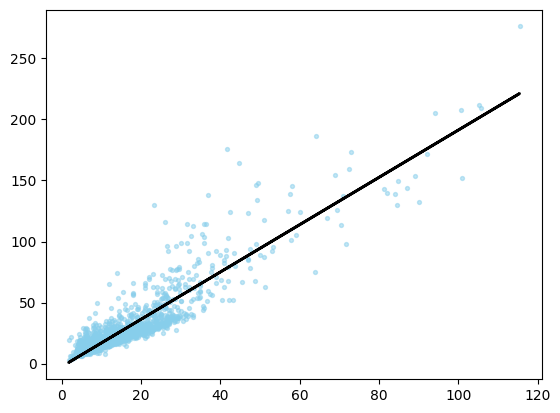

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_PM_notnull['PM2.5 (μg/m3)'], df_PM_notnull['PM10 (μg/m3)'], test_size=0.2, random_state=55)

# Creating a linear regression model
model_2 = LinearRegression()

X_train = X_train.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
model_2.fit(X_train, y_train)

y_pred = model_2.predict(X_test)

model2_coeff = model_2.coef_
model2_intercept = model_2.intercept_

print("Coefficients:", model2_coeff)
print("Intercept:", model2_intercept)

# # Mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
# Plotting the data and the regression line
plt.scatter(X_test, y_test, color='skyblue', s=8, alpha=0.5)
plt.plot(X_test, y_pred, color='black', linewidth=2)

plt.show()

Ponieważ model 'difference ~ PM2.5 (μg/m3)' radził sobie słabo - R2 mniejsze niż 0.5, w 2 scenariuszu użyty zostanie model 'PM10 (μg/m3) ~ PM2.5 (μg/m3)', który spisuje się gorzej niż model dla pierwszego scenariusza - R2 na poziomie ok. 0.75, ale wciąż wyniki zdają się być satysfakcjonujące.

**Uzupełnienie wartości brakujących w kolumnach 'PM10 (μg/m3)' i 'PM2.5 (μg/m3)':**

**Scenariusz 1**
(PM10 nie jest nullem, PM2.5 tak)

W tym scenariuszu przewidywana jest wartość różnicy między zmiennymi, którą następnie należy odjąć od wartości kolumny 'PM10 (μg/m3)'.

In [23]:
print("Liczba nulli w kolumnie 'PM2.5 (μg/m3)' przed operacją:")
print(len(df_filled[df_filled['PM2.5 (μg/m3)'].isnull()]))
df_filled['PM2.5 (μg/m3)'] = df_filled.apply(lambda row: row['PM10 (μg/m3)'] - (row['PM10 (μg/m3)'] * model1_coeff[0][0] + model1_intercept[0]) if pd.isnull(row['PM2.5 (μg/m3)']) else row['PM2.5 (μg/m3)'], axis=1)

print("\nLiczba nulli w kolumnie 'PM2.5 (μg/m3)' po operacji:")
print(len(df_filled[df_filled['PM2.5 (μg/m3)'].isnull()]))
show(df_filled['PM2.5 (μg/m3)'])

Liczba nulli w kolumnie 'PM2.5 (μg/m3)' przed operacją:
17143

Liczba nulli w kolumnie 'PM2.5 (μg/m3)' po operacji:
4858


PM2.5 (μg/m3)
Loading... (need help?)


**Scenariusz 2**
(PM10 jest nullem, PM2.5 nie)

W tym scenariuszu przewidywana jest bezpośrednio wartość kolumny 'PM10 (μg/m3)' w zależności od 'PM2.5 (μg/m3)'.

In [24]:
print("Liczba nulli w kolumnie 'PM10 (μg/m3)' przed operacją:")
print(len(df_filled[df_filled['PM10 (μg/m3)'].isnull()]))
df_filled['PM10 (μg/m3)'] = df_filled.apply(lambda row: (row['PM2.5 (μg/m3)'] * model2_coeff[0][0] + model2_intercept[0]) if pd.isnull(row['PM10 (μg/m3)']) else row['PM10 (μg/m3)'], axis=1)

print("\nLiczba nulli w kolumnie 'PM10 (μg/m3)' po operacji:")
print(len(df_filled[df_filled['PM10 (μg/m3)'].isnull()]))
show(df_filled['PM10 (μg/m3)'])


Liczba nulli w kolumnie 'PM10 (μg/m3)' przed operacją:
11082

Liczba nulli w kolumnie 'PM10 (μg/m3)' po operacji:
4858


PM10 (μg/m3)
Loading... (need help?)


Dzięki przeprowadzeniu operacji uzupełniania wartości brakujących w kolumnach 'PM10 (μg/m3)' oraz 'PM2.5 (μg/m3)' znacząco zredukowana została ilość nulli a także zwiększyły się możliwości interpretacyjne tego zbioru danych.

Ze względu na brak podobnej zależności dla zmiennej 'NO2 (μg/m3)', wartości brakujące tej kolumny nie będą uzupełniane.

Podobnie, wartości brakujące nie będą uzupełniane dla kolumn związanych z pokryciem czasowym danych.

**Braki w danych po uzupełnianiu:**

In [25]:
df_null = pd.concat([np.round(df_filled.isnull().sum()/len(df)*100,3), df_filled.isnull().sum()], axis=1)
df_null.columns = ['null percent', 'null count']
df_null

,null percent,null count
Region,0.000,0
ISO3,0.000,0
Country,0.000,0
City,0.000,0
Year,0.000,0
PM2.5 (μg/m3),15.091,4858
PM10 (μg/m3),15.091,4858
NO2 (μg/m3),31.037,9991
PM25 temporal coverage (%),77.401,24916
PM10 temporal coverage (%),83.284,26810


- Brakujące wartości w kolumnie 'PM2.5 (μg/m3)' zredukowano z  53.254% do 15.091%	
- Brakujące wartości w kolumnie 'PM10 (μg/m3)'	zredukowano z 34.426% do 15.091%	

## EDA dla różnych poziomów generalizacji

In [ ]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
gpd.datasets.available

: 